In [1]:
import numpy as np
import pandas as pd
import pickle
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import os 
from functions import *
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy import stats

# Load dataset

In [2]:
S = pd.read_csv('../data/IMdata/S.csv')
S = pd.read_csv('../data/IMdata/S.csv',index_col=0)
A = pd.read_csv('../data/IMdata/A.csv',index_col=0)
log_rpkm_norm = pd.read_csv('../data/IMdata/log_rpkm_norm.csv', index_col=0)
regulons = load_pickle('../data/IMdata/lpwcfs1_regulons.pkl')
IM_list = list(S.columns)
sample_list = list(A.columns)

# pH response

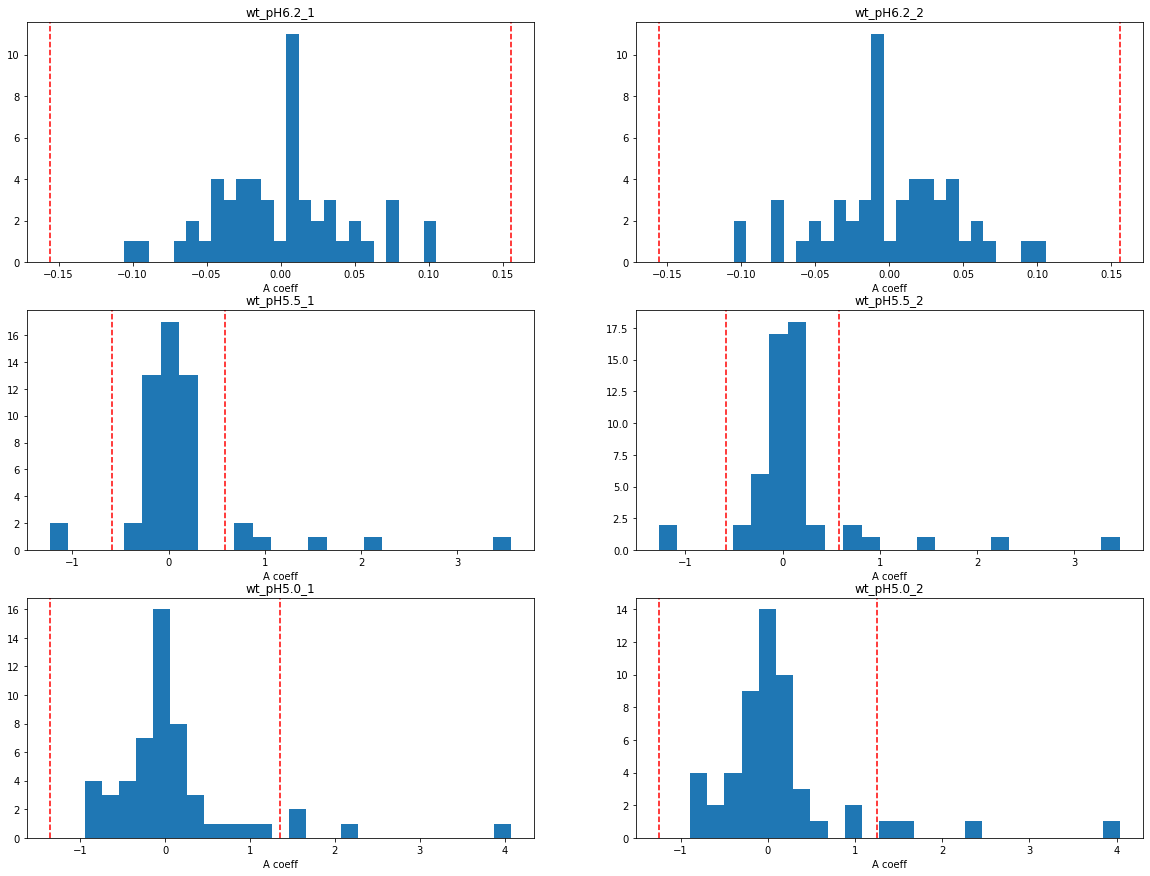

In [3]:
fig, axs = plt.subplots(3,2,figsize=(20,15))
for i in range(6):
    x,y = int(i/2), int(i%2)
    title_name = sample_list[i]
    thres = compute_threshold( A , title_name ,cutoff=10)
    axs[x][y].hist(A[title_name], bins=25);
    axs[x][y].axvline(x=thres, color='r', linestyle='--')
    axs[x][y].axvline(x=-thres, color='r', linestyle='--')
    axs[x][y].set_title(title_name)
    axs[x][y].set_xlabel('A coeff')

Text(15.0, 0.5, 'I-modulon')

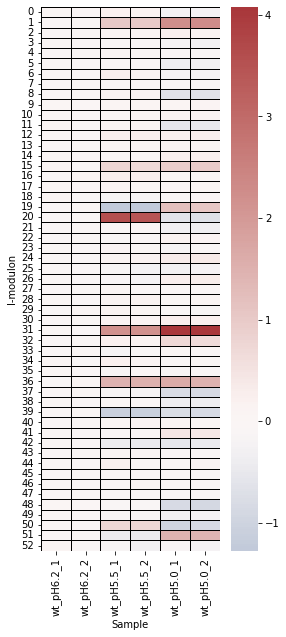

In [6]:
fig, ax = plt.subplots(1,1, figsize=(4,10))
sns.heatmap( A[A.columns[0:6]], yticklabels=True, 
            linecolor='black',linewidths=1,cmap="vlag",
           center=0, ax = ax)
ax.set_xlabel('Sample')
ax.set_ylabel('I-modulon')

# Different carbon sources

In [4]:
A_cc = A[A.columns[-22:]]
A_cc.head()

,wt_GLC_rep1,wt_GLC_rep2,wt_PAC1_rep1,wt_PAC1_rep2,wt_PAC2_rep1,wt_PAC2_rep2,wt_FOSPAC1_rep1,wt_FOSPAC1_rep2,wt_FOSPAC2_rep1,wt_FOSPAC2_rep2,...,wt_HMOPAC1_rep1,wt_HMOPAC1_rep2,wt_HMOPAC2_rep1,wt_HMOPAC2_rep2,wt_XG_rep1,wt_XG_rep2,wt_XGPAC1_rep1,wt_XGPAC1_rep2,wt_XGPAC2_rep1,wt_XGPAC2_rep2
0,1.552385,1.385998,1.184340,1.776755,0.437850,1.398256,1.232406,1.479505,1.499234,1.390822,...,1.236147,1.589680,1.533176,1.335364,1.603347,2.941285,1.413772,1.131234,2.639196,0.858895
1,4.823618,4.453225,3.304981,3.422716,4.464863,4.668740,4.011575,4.037251,5.323341,5.117616,...,2.638466,2.218503,4.221350,3.758609,3.751051,3.284629,3.955745,4.829204,2.501583,2.986544
2,-0.461296,-0.283148,0.395359,0.515539,-0.026778,-0.149412,0.743882,0.513450,-0.564312,-0.482974,...,0.178716,-0.032237,-0.235157,-0.382110,-0.448638,-0.647191,-0.350460,-0.203075,-0.071564,0.032883
3,-0.958755,-0.693182,-0.706276,-0.668245,-1.527330,-0.228760,-1.549744,-1.414387,-1.082056,-0.687218,...,0.805832,-0.011581,0.622940,3.824816,-2.590137,-3.249639,-0.861539,1.055788,-0.043893,-0.952510
4,7.049439,6.889797,7.721243,7.875266,6.930013,6.437698,7.598698,7.376310,7.698681,7.470097,...,7.472611,7.545520,7.714871,7.599559,8.237847,7.805440,8.755065,8.031920,7.784073,8.220298


Text(69.0, 0.5, 'I-modulon')

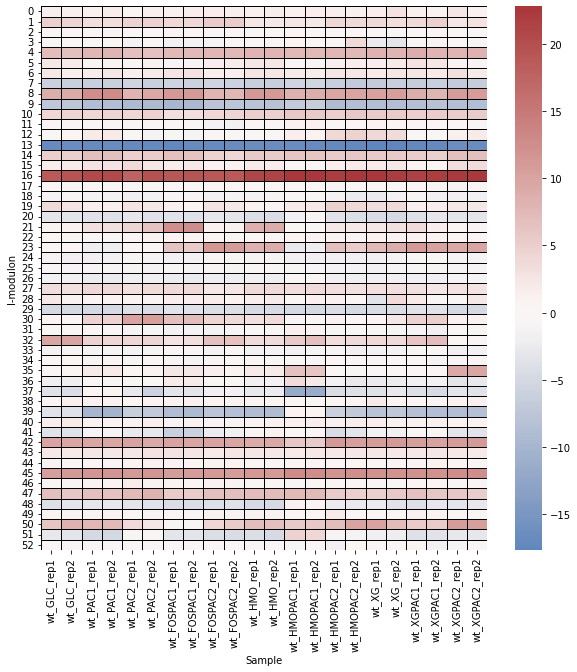

In [5]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.heatmap( A_cc, yticklabels=True, 
            linecolor='black',linewidths=1,
            cmap= "vlag",center=0, ax = ax)
ax.set_xlabel('Sample')
ax.set_ylabel('I-modulon')

Text(0.5, 1.0, 'Different carbon sources(p-value < 0.05)')

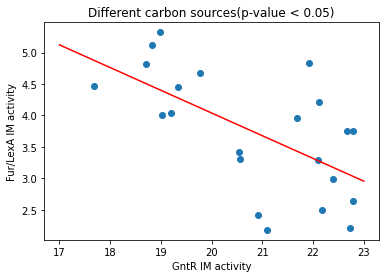

In [9]:
def func(x, a, b ):
    return a*x + b 
popt, pcov = curve_fit(func, A_cc.iloc[16], A_cc.iloc[1])

plt.scatter(A_cc.iloc[16], A_cc.iloc[1])
x = np.arange(17,24)
plt.plot(x, popt[0]*x+popt[1], color='r')
plt.xlabel('GntR IM activity')
plt.ylabel('Fur/LexA IM activity')
plt.title('Different carbon sources(p-value < 0.05)')

Text(0.5, 1.0, 'Different habitats(p-value < 0.05)')

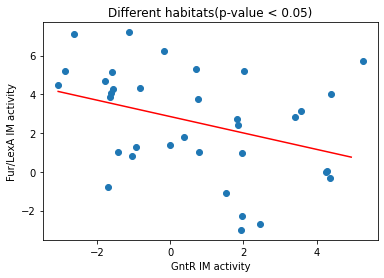

In [8]:
A_hab = A[ A.columns[42:78] ]
def func(x, a, b ):
    return a*x + b 
popt, pcov = curve_fit(func, A_hab.iloc[16][1:], A_hab.iloc[1][1:])
plt.scatter(A_hab.iloc[16][1:], A_hab.iloc[1][1:])
x = np.arange(min(A_hab.iloc[16][1:]), max(A_hab.iloc[16][1:]))
plt.plot(x, popt[0]*x+popt[1], color='r')
plt.xlabel('GntR IM activity')
plt.ylabel('Fur/LexA IM activity')
plt.title('Different habitats(p-value < 0.05)')